In [1]:
from IPython.display import clear_output
import numpy as np
from framework.io.io_functions import Reader, Writer
from framework.base.dataset import Dataset
from framework.reconstruction.parameter import Parameter
from framework.transformers.dfts import DFT1D, NUFFT1D
import matplotlib.pyplot as plt
from framework.objectivefunction.ofunction import OFunction
from framework.utils.utilities import real_to_complex, complex_to_real, find_pixel
from framework.objectivefunction.priors import TSV, TV, L1, Chi2
from framework.optimization.optimizer import FISTA, ADMM, SDMM, GradientBasedMethod
from framework.utils.analytical_functions import Gaussian
from framework.transformers.gridding import Gridding
from scipy.constants import c
from pynufft import NUFFT
from scipy import signal as sci_signal
import itertools

In [2]:
# Read data
P = np.load("polarized_emission.npy")
#P = np.load("P231_544.npy")
sigma = np.load("sigmas.npy")
nu = np.load("freqs.npy")

In [3]:
measurements = Dataset(nu=nu, data=P, sigma=sigma)

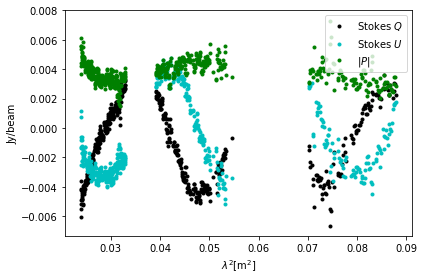

In [4]:
plt.plot(measurements.lambda2, measurements.data.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, measurements.data.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(measurements.data), 'g.', label=r"$|P|$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('polarized.png', dpi=100, bbox_inches='tight')

In [5]:
parameter = Parameter()

In [6]:
parameter.calculate_cellsize(dataset=measurements)

FWHM of the main peak of the RMTF: 54.084 rad/m^2
Maximum recovered width structure: 131.556 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 14737.933


In [7]:
nufft = NUFFT1D(dataset=measurements, parameter=parameter, solve=True)

In [8]:
dft = DFT1D(dataset=measurements, parameter=parameter)

In [9]:
F_dirty = dft.backward(measurements.data)

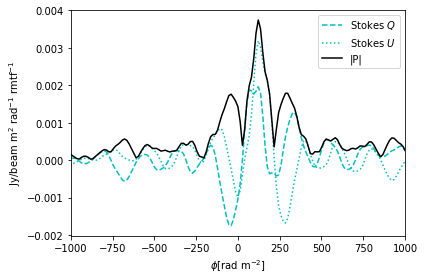

In [10]:
plt.plot(parameter.phi, F_dirty.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_dirty.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_dirty), 'k-', label=r"|P|")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000,1000])
plt.tight_layout()
plt.savefig('fdirty.png', dpi=100, bbox_inches='tight')

In [11]:
idx_noise = np.where(np.abs(parameter.phi)>14000)
noise_F = np.std(0.5*(F_dirty[idx_noise].real + F_dirty[idx_noise].imag))
#noise_F = np.std(sigma)
noise_F

1.931999e-05

In [12]:
P_back = nufft.forward_normalized(F_dirty)

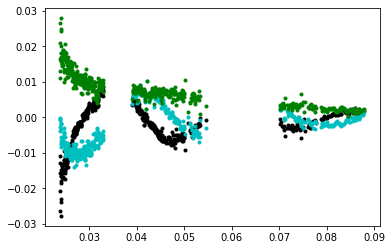

In [13]:
plt.plot(measurements.lambda2, P_back.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, P_back.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(P_back), 'g.', label=r"$|P|$")

In [14]:
F_back = nufft.backward(measurements.data)

(-1000.0, 1000.0)

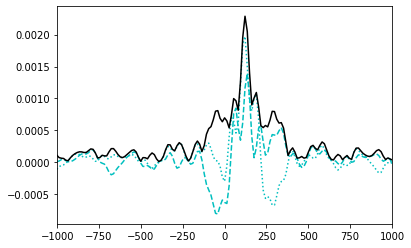

In [15]:
plt.plot(parameter.phi, F_back.real, 'c--', label=r"Real part")
plt.plot(parameter.phi, F_back.imag, 'c:', label=r"Imaginary part")
plt.plot(parameter.phi, np.abs(F_back), 'k-', label=r"Amplitude")
plt.xlim([-1000,1000])

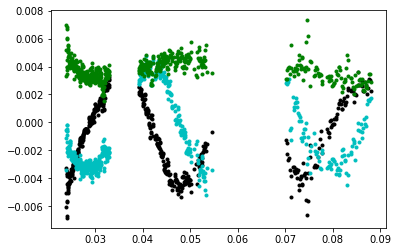

In [16]:
P_back = nufft.forward_normalized(F_back)
plt.plot(measurements.lambda2, P_back.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, P_back.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(P_back), 'g.', label=r"$|P|$")

In [17]:
lambda_l1 = np.sqrt(2.0 * measurements.m + 4.0 * np.sqrt(measurements.m))*noise_F
#lambda_l1 /= 2
#lambda_l1=0.5
lambda_tsv = 0.0
chi2 = Chi2(dft_obj=nufft)
l1 = L1(reg=lambda_l1)
tsv = TSV(reg=lambda_tsv)
# F_func = [chi2(P, dft, W), L1(lambda_l1)]
F_func = [chi2, l1, tsv]
f_func = [chi2]
g_func = [l1, tsv]

F_obj = OFunction(F_func)
f_obj = OFunction(f_func)
g_obj = OFunction(g_func)

In [18]:
len(F_back)

2176

In [19]:
len(parameter.data)

2176

In [20]:
parameter.data = F_back

In [21]:
parameter.n

2176

In [22]:
parameter.complex_data_to_real()

In [23]:
nufft.parameter.n

2176

In [24]:
parameter.n

4352

In [25]:
opt = FISTA(guess_param=parameter, F_obj=F_obj, fx=chi2, gx=g_obj, noise=noise_F, verbose=True)
#opt = FISTA(i_guess=F_real, F_obj=F_obj, fx=chi2, gx=g_obj, maxiter=1000, noise=1e-5, verbose=True)
obj, X = opt.run()

Iterations set to 34
Iteration:  0  objective function value: 33857.46330


(-1000.0, 1000.0)

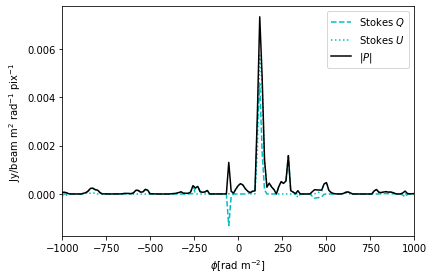

In [26]:
X.real_data_to_complex()

plt.plot(parameter.phi, X.data.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, X.data.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(X.data), 'k-', label=r"$|P|$")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ pix$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlim([-1000,1000])

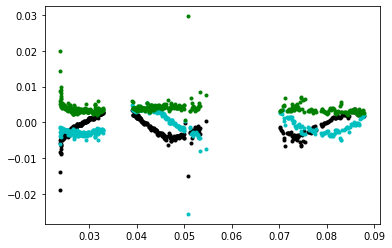

In [27]:
plt.plot(measurements.lambda2, measurements.model_data.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, measurements.model_data.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(measurements.model_data), 'g.', label=r"$|P|$")
#plt.ylim([-0.007,0.008])

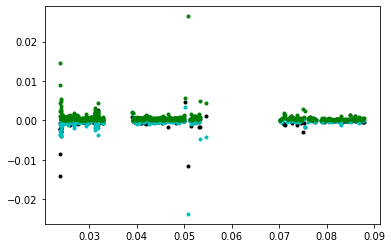

In [28]:
plt.plot(measurements.lambda2, measurements.residual.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, measurements.residual.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(measurements.residual), 'g.', label=r"$|P|$")

In [29]:
gridding = Gridding(measurements)

In [30]:
gridded_data = gridding.run()

In [31]:
np.mean(gridded_data.residual.real)

-1.348526e-05

In [32]:
np.mean(gridded_data.residual.imag)

-3.6213016e-05

In [33]:
hist_real,bins_real,hist_imag,bins_imag = gridded_data.histogram_residuals()

<BarContainer object of 11 artists>

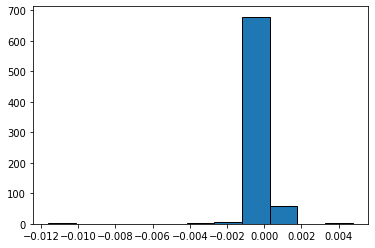

In [34]:
plt.bar(bins_real[:-1], hist_real, width=np.diff(bins_real), edgecolor="black", align="edge")

(-1000.0, 1000.0)

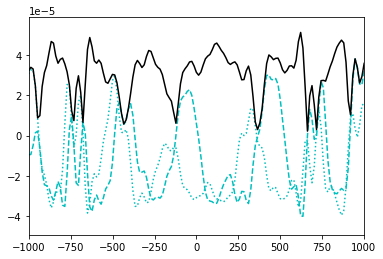

In [35]:
F_residual = nufft.backward(measurements.residual)
plt.plot(parameter.phi, F_residual.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_residual.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_residual), 'k-', label=r"$|P|$")
plt.xlim([-1000,1000])

In [36]:
lags, autocorr_res, bound, percentage_real_in, percentage_imag_in = gridded_data.assess_residuals()

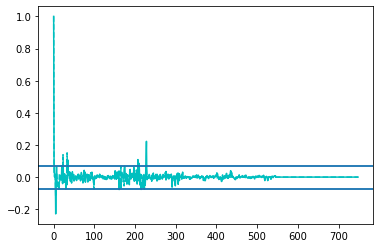

In [37]:
plt.plot(lags, autocorr_res.real, 'c-', label=r"Real part")
plt.plot(lags, autocorr_res.imag, 'c--', label=r"Imaginary part")
plt.axhline(-bound)
plt.axhline(bound)
plt.axhline(-bound)
plt.axhline(bound)
plt.grid()
plt.grid()

In [38]:
percentage_real_in, percentage_imag_in

(97.99732977303071, 99.3324432576769)

In [39]:
conv_model = X.convolve() + F_residual

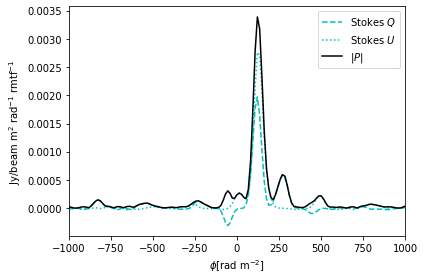

In [40]:
plt.plot(parameter.phi, conv_model.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, conv_model.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(conv_model), 'k-', label=r"$|P|$")
plt.xlim([-1000,1000])
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("restored.png", dpi=100)

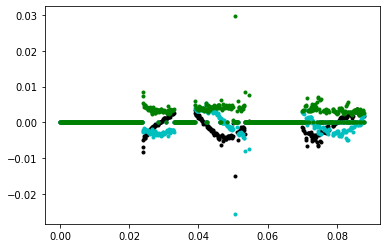

In [42]:
plt.plot(gridded_data.lambda2, gridded_data.model_data.real, 'k.', label=r"Stokes $Q$")
plt.plot(gridded_data.lambda2, gridded_data.model_data.imag, 'c.', label=r"Stokes $U$")
plt.plot(gridded_data.lambda2, np.abs(gridded_data.model_data), 'g.', label=r"$|P|$")

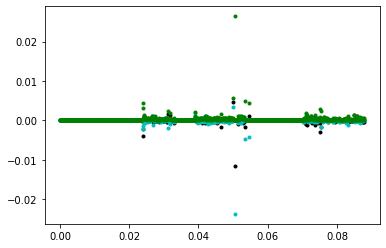

In [44]:
plt.plot(gridded_data.lambda2, gridded_data.residual.real, 'k.', label=r"Stokes $Q$")
plt.plot(gridded_data.lambda2, gridded_data.residual.imag, 'c.', label=r"Stokes $U$")
plt.plot(gridded_data.lambda2, np.abs(gridded_data.residual), 'g.', label=r"$|P|$")